In [1]:
import glob
import numpy as np
from pickle import dump

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [3]:
class ClassifierLSTM(nn.Module):
    def __init__(self, device, context_frames):
        super(ClassifierLSTM, self).__init__()
        self.device = device
        self.context_frames = context_frames
        self.lstm = nn.LSTM(32, 200).to(device)  # tactile
        self.fc1 = nn.Linear(200, 40).to(device)
        self.fc2 = nn.Linear(40, 1).to(device)
        self.tan_activation = nn.Tanh().to(device)
        self.relu_activation = nn.ReLU().to(device)
        self.softmax_activation = nn.Softmax(dim=1).to(device) #we don't use this because BCE loss in pytorch automatically applies the the Sigmoid activation
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, tactiles):
        batch_size__ = tactiles.shape[1]
        outputs = []
        hidden = (torch.zeros(1, batch_size__, 200, device=torch.device('cuda')), torch.zeros(1, batch_size__, 200, device=torch.device('cuda')))
        for index, sample_tactile_prediction in enumerate(tactiles):
            lstm_out, self.hidden_lstm = self.lstm(sample_tactile_prediction.view(1, batch_size__, -1), hidden)
            lstm_out_drop = self.dropout(lstm_out)
            fc1_out = self.relu_activation(self.fc1(lstm_out_drop))
            fc1_out_drop = self.dropout(fc1_out)
            fc2_out = self.tan_activation(self.fc2(fc1_out_drop))
            outputs.append(fc2_out.view(batch_size__, -1))


        return torch.stack(outputs)

In [4]:
data_dir = '/home/kia/Kiyanoush/UoLincoln/Projects/Tactile_control/tactile_prediction/uninversal_trainer/ACTP/saved_models/model_29_07_2022_11_27_kins/test_results'
files = sorted(glob.glob(data_dir + '/*'))

**This is for Single Feature Input**

In [5]:
for index, file in enumerate(files):
    if index == 0:
        t10_prediction_full = np.load(file + '/prediction_data.npy')[:, :, :32]
        slip_data_full = np.load(file + '/slip_data.npy')
    else:
        t10_prediction = np.load(file + '/prediction_data.npy')[:, :, :32]
        slip_data = np.load(file + '/slip_data.npy')
        t10_prediction_full = np.concatenate((t10_prediction_full, t10_prediction), axis=0)
        slip_data_full = np.concatenate((slip_data_full, slip_data), axis=0)

**This is for Delta Feature Input**

In [5]:
for index, file in enumerate(files):
    if index == 0:
        t10_prediction_full = np.load(file + '/prediction_data.npy')[:, :, :32]
        slip_data_full = np.load(file + '/slip_data.npy')

        t10_prediction_diff = np.diff(t10_prediction_full, axis=0)

        t10_prediction_full = np.concatenate((t10_prediction_full[1:], t10_prediction_diff), axis=2)
        slip_data_full = slip_data_full[1:]
    else:
        t10_prediction = np.load(file + '/prediction_data.npy')[:, :, :32]
        slip_data = np.load(file + '/slip_data.npy')

        t10_prediction_diff = np.diff(t10_prediction, axis=0)

        t10_prediction = np.concatenate((t10_prediction[1:], t10_prediction_diff), axis=2)
        slip_data = slip_data[1:]

        t10_prediction_full = np.concatenate((t10_prediction_full, t10_prediction), axis=0)
        slip_data_full = np.concatenate((slip_data_full, slip_data), axis=0)

In [6]:
print(t10_prediction_full.shape)
print(slip_data_full.shape)

(229760, 10, 32)
(229760, 10)


In [7]:
def detemporalize(X_seq):
    x_2d = np.zeros((X_seq.shape[0] * X_seq.shape[1], X_seq.shape[2]))
    for index, seq in enumerate(X_seq):
        x_2d[10*index:10*(index+1)] = seq
       
    return x_2d

In [8]:
X_train, X_test, y_train, y_test = train_test_split(t10_prediction_full, slip_data_full, test_size=0.3, random_state=42)

X_train_2d = detemporalize(X_train)
X_test_2d = detemporalize(X_test)
scaler = StandardScaler()
scaler = scaler.fit(X_train_2d)
X_train = scaler.transform(X_train_2d)
X_test = scaler.transform(X_test_2d)
dump(scaler, open('/home/kia/Kiyanoush/UoLincoln/Projects/Tactile_control/slip_classification/kins/classifier_standard_scaler.pkl', 'wb'))

In [9]:
def temporalize(data_2d, seq_len):
    x_3d = np.zeros((int(data_2d.shape[0] / seq_len), seq_len, data_2d.shape[1]))
    for index in range(x_3d.shape[0]):
        x_3d[index] = data_2d[10*index:10*(index+1)]
    
    return x_3d

In [10]:
X_train = temporalize(X_train, 10)
X_test = temporalize(X_test, 10)

In [11]:
## train data
class TrainData(Dataset):
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data

    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]

    def __len__ (self):
        return len(self.X_data)

train_data = TrainData(X_train, y_train)

## test data    
class TestData(Dataset):    
    def __init__(self, X_data):
        self.X_data = X_data

    def __getitem__(self, index):
        return self.X_data[index]

    def __len__ (self):
        return len(self.X_data)
    
test_data = TestData(X_test)

In [12]:
train_loader = DataLoader(dataset=train_data, batch_size=128, shuffle=True, drop_last=True)
test_loader = DataLoader(dataset=test_data, batch_size=1)

In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model = ClassifierLSTM(device, context_frames=10)
model.to(device)
weight = torch.Tensor([8]).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=weight)
optimizer = optim.Adam(model.parameters(), lr=0.001)
print(model)

cuda:0
ClassifierLSTM(
  (lstm): LSTM(32, 200)
  (fc1): Linear(in_features=200, out_features=40, bias=True)
  (fc2): Linear(in_features=40, out_features=1, bias=True)
  (tan_activation): Tanh()
  (relu_activation): ReLU()
  (softmax_activation): Softmax(dim=1)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [14]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(count_parameters(model))

195281


In [15]:
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/(y_test.shape[0]*y_test.shape[1])
    acc = torch.round(acc * 100)
    
    return acc

In [16]:
epochs = 70
score_file = np.zeros((epochs, 2))
best_val_acc = 0.0
for e in range(1, epochs+1):
    model.train()
    epoch_loss = 0
    epoch_acc = 0
    model_save = ""
    for X_batch, y_batch in train_loader:
        X_batch = X_batch.type(torch.FloatTensor)
        y_batch = y_batch.type(torch.FloatTensor)
        
        X_batch = X_batch.permute(1, 0, 2).to(device)
        y_batch = y_batch.to(device)

        optimizer.zero_grad()
        
        y_pred = model(X_batch)
        y_pred = y_pred.permute(1, 0, 2).view(128, 10)
        
        loss = criterion(y_pred, y_batch)
        acc = binary_acc(y_pred, y_batch)
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()

    score_file[e-1, 0] = epoch_acc/len(train_loader)
    
    with torch.no_grad():
        y_pred_list = []
        model.eval()
        for X_batch in test_loader:
            X_batch = X_batch.type(torch.FloatTensor)
            X_batch = X_batch.permute(1, 0, 2).to(device)
            
            X_batch = X_batch.to(device)
            y_test_pred = model(X_batch)

            y_test_pred = y_test_pred.permute(1, 0, 2).view(1, 10)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
    
    y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
    
    val_acc = accuracy_score(y_test, y_pred_list) * 100

    score_file[e-1, 1] = val_acc

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model, '/home/kia/Kiyanoush/UoLincoln/Projects/Tactile_control/slip_classification/kins/classifier_lstm')
        model_save = "saved model"


    print(f'Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader):.5f} | Train Acc: {epoch_acc/len(train_loader):.3f} | Val Acc: {val_acc:.3f} | {model_save}')

np.save('/home/kia/Kiyanoush/UoLincoln/Projects/Tactile_control/slip_classification/Long_horizon/scores.npy', score_file)

Epoch 001: | Loss: 0.96816 | Train Acc: 85.597 | Val Acc: 84.255 | saved model
Epoch 002: | Loss: 0.91703 | Train Acc: 87.986 | Val Acc: 83.330 | 
Epoch 003: | Loss: 0.91359 | Train Acc: 88.209 | Val Acc: 84.739 | saved model
Epoch 004: | Loss: 0.91090 | Train Acc: 88.401 | Val Acc: 84.719 | 
Epoch 005: | Loss: 0.90775 | Train Acc: 88.705 | Val Acc: 85.385 | saved model
Epoch 006: | Loss: 0.90165 | Train Acc: 89.365 | Val Acc: 85.610 | saved model
Epoch 007: | Loss: 0.89708 | Train Acc: 89.776 | Val Acc: 86.410 | saved model
Epoch 008: | Loss: 0.89455 | Train Acc: 89.951 | Val Acc: 86.746 | saved model
Epoch 009: | Loss: 0.89218 | Train Acc: 90.158 | Val Acc: 87.216 | saved model
Epoch 010: | Loss: 0.89010 | Train Acc: 90.350 | Val Acc: 87.297 | saved model
Epoch 011: | Loss: 0.88886 | Train Acc: 90.461 | Val Acc: 87.295 | 
Epoch 012: | Loss: 0.88771 | Train Acc: 90.584 | Val Acc: 87.297 | 
Epoch 013: | Loss: 0.88638 | Train Acc: 90.674 | Val Acc: 87.776 | saved model
Epoch 014: | Loss

In [17]:
model = torch.load('/home/kia/Kiyanoush/UoLincoln/Projects/Tactile_control/slip_classification/Class_sequence/single_feature/single_feature_classifier_lstm').to(device)
model.eval()

ClassifierLSTM(
  (lstm): LSTM(32, 200)
  (fc1): Linear(in_features=200, out_features=40, bias=True)
  (fc2): Linear(in_features=40, out_features=1, bias=True)
  (tan_activation): Tanh()
  (relu_activation): ReLU()
  (softmax_activation): Softmax(dim=1)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [18]:
y_pred_list = []
model.eval()

with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.type(torch.FloatTensor)
        X_batch = X_batch.permute(1, 0, 2).to(device)
        
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        y_test_pred = y_test_pred.permute(1, 0, 2).view(1, 50)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())
        
y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

In [19]:
print(classification_report(y_test, y_pred_list))

              precision    recall  f1-score   support

           0       0.96      0.94      0.95      2577
           1       0.96      0.97      0.97      2624
           2       0.96      0.97      0.97      2687
           3       0.96      0.97      0.97      2723
           4       0.98      0.97      0.97      2778
           5       0.97      0.98      0.98      2820
           6       0.98      0.98      0.98      2877
           7       0.97      0.98      0.98      2925
           8       0.98      0.98      0.98      2979
           9       0.98      0.97      0.98      3023
          10       0.98      0.97      0.98      3085
          11       0.98      0.98      0.98      3142
          12       0.98      0.98      0.98      3219
          13       0.98      0.98      0.98      3281
          14       0.98      0.97      0.97      3353
          15       0.98      0.97      0.97      3417
          16       0.98      0.97      0.97      3460
          17       0.98    

/home/kia/miniconda3/envs/tensorflow/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/kia/miniconda3/envs/tensorflow/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [20]:
y_pred_list = np.asarray(y_pred_list)

Text(0.5, 32.09375, 'Predicted class')

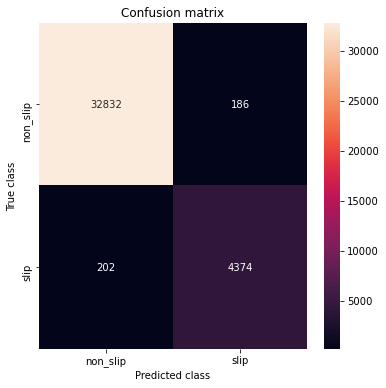

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt
conf_matrix = confusion_matrix(y_test[:, -1], y_pred_list[:, -1])
LABELS = ["non_slip","slip"]
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
# plt.savefig('confusion_matrix.png')

In [29]:
import time

y_pred_list = []
model.eval()
count = 0
t1 = time.time()
for X_batch, y_batch in train_loader:
    X_batch = X_batch.type(torch.FloatTensor)
    X_batch = X_batch.permute(1, 0, 2).to(device)
    
    X_batch = X_batch.to(device)
    y_test_pred = model(X_batch)
    y_test_pred = torch.sigmoid(y_test_pred)
    y_pred_tag = torch.round(y_test_pred)
    y_pred_list.append(y_pred_tag.cpu().detach().numpy())
    t2 = time.time()
    break

print(t2-t1)

0.025365114212036133
